# Experient imputation methods with AIF360

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.completer import complete_by_mean_col, complete_by_mean_col_v2
from utils.completer import complete_by_multi, complete_by_multi_v2
from utils.completer import complete_by_similar_row, complete_by_similar_row_v2
from utils.generator import gen_complete_random
from utils.data import create_adult_dataset

### Learning Fair Representations (LFR)
[example notebook](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lfr.ipynb)  

------

The idea is to first apply imputation on original dataset (adult dataset here)  
Then feed the converted dataset into LFR to see any difference  

------

Note:  
In order to LFR to work on Python3.8  
Should install LFR directly from github, instead of from pip  

In [2]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [4]:
data = create_adult_dataset()
print(data.X.shape)
print(data.X.isnull().sum().sum())

(32561, 10)
0


In [5]:
data_incomplete = gen_complete_random(data, random_ratio=0.2)
print(data_incomplete.X.isnull().sum())

gen_complete_random: 58244 NaN values have been inserted
age               6420
workclass         6520
education         6518
education-num     6383
marital-status    6552
occupation        6485
relationship      6494
race              6438
hours-per-week    6434
sex                  0
dtype: int64


In [6]:
data_complete = complete_by_mean_col(data_incomplete)
print(data_complete.X.isnull().sum())

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
hours-per-week    0
sex               0
dtype: int64


In [7]:
data_complete.y_encoder.classes_

array([' <=50K', ' >50K'], dtype=object)

In [8]:
data_complete.categorical_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race']

In [9]:
data_complete.protected_features

['sex']

In [10]:
# convert to standard dataset
from sklearn.model_selection import train_test_split
tmp_df = pd.concat([data_complete.X, pd.DataFrame(data_complete.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_imputed_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                     protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                     features_to_keep=data_complete.X.columns.tolist(),
                                     instance_weights_name=None, features_to_drop=[],
                                     custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_imputed_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                    protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                    features_to_keep=data_complete.X.columns.tolist(),
                                    instance_weights_name=None, features_to_drop=[],
                                    custom_preprocessing=None, categorical_features=data_complete.categorical_features)
print(tmp_df_train.shape)
print(tmp_df_test.shape)

(22792, 11)
(9769, 11)


In [11]:
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]
metric_imputed_train = BinaryLabelDatasetMetric(data_imputed_train, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
metric_imputed_test = BinaryLabelDatasetMetric(data_imputed_test, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print(metric_imputed_train.mean_difference())
print(metric_imputed_test.mean_difference())

-0.19869410188167788
-0.19062676377058413


In [12]:
scaler = StandardScaler()
data_imputed_train.features = scaler.fit_transform(data_imputed_train.features)
data_imputed_test.features = scaler.transform(data_imputed_test.features)

In [14]:
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.01, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(data_imputed_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.7346195455772178, L_x: 2.5687581721984882,  L_y: 0.6942481905756902,  L_z: 0.007341886639771314
step: 250, loss: 0.7346195716448645, L_x: 2.5687582203647388,  L_y: 0.6942482127489367,  L_z: 0.007341888346140181
step: 500, loss: 0.7346195363902224, L_x: 2.5687582009859034,  L_y: 0.6942481702939289,  L_z: 0.007341892043217224
step: 750, loss: 0.6474704396021584, L_x: 2.5686706103869,  L_y: 0.6075376798011145,  L_z: 0.007123026848587476
step: 1000, loss: 0.6474704595474631, L_x: 2.5686706229526335,  L_y: 0.6075377010439631,  L_z: 0.007123026136986822
step: 1250, loss: 0.6474704621886784, L_x: 2.5686706198010594,  L_y: 0.6075377012023272,  L_z: 0.00712302739417032
step: 1500, loss: 0.5888703548237946, L_x: 2.5681439510542496,  L_y: 0.5508710982562816,  L_z: 0.006158908528485248
step: 1750, loss: 0.5888703637439808, L_x: 2.5681439189247537,  L_y: 0.5508711068743918,  L_z: 0.006158908840170707
step: 2000, loss: 0.5864081763037629, L_x: 2.5679923555247375,  L_y: 0.54962964532

In [15]:
data_imputed_transf_train = TR.transform(data_imputed_train)
data_imputed_transf_test = TR.transform(data_imputed_test)
print(classification_report(data_imputed_test.labels, data_imputed_transf_test.labels, zero_division=0))
metric_imputed_transf_train = BinaryLabelDatasetMetric(data_imputed_transf_train, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
metric_imputed_transf_test = BinaryLabelDatasetMetric(data_imputed_transf_test, 
                                                      unprivileged_groups=unprivileged_groups,
                                                      privileged_groups=privileged_groups)
print(metric_imputed_transf_train.mean_difference())
print(metric_imputed_transf_test.mean_difference())

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.87      7461
         1.0       0.00      0.00      0.00      2308

    accuracy                           0.76      9769
   macro avg       0.38      0.50      0.43      9769
weighted avg       0.58      0.76      0.66      9769

0.0
0.0


In [16]:
def draw(dataset_orig_test, dataset_transf_test):
    from collections import OrderedDict
    from aif360.metrics import ClassificationMetric

    def compute_metrics(dataset_true, dataset_pred, 
                        unprivileged_groups, privileged_groups,
                        disp = True):
        """ Compute the key metrics """
        classified_metric_pred = ClassificationMetric(dataset_true,
                                                     dataset_pred, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        metrics = OrderedDict()
        metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                                 classified_metric_pred.true_negative_rate())
        metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
        metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
        metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
        metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
        metrics["Theil index"] = classified_metric_pred.theil_index()
    
        if disp:
            for k in metrics:
                print("%s = %.4f" % (k, metrics[k]))
    
        return metrics
    bal_acc_arr_transf = []
    disp_imp_arr_transf = []

    class_thresh_arr = np.linspace(0.01, 0.99, 100)

    dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
    dataset_transf_test_new.scores = dataset_transf_test.scores

    for thresh in class_thresh_arr:
        fav_inds = dataset_transf_test_new.scores > thresh
        dataset_transf_test_new.labels[fav_inds] = 1.0
        dataset_transf_test_new.labels[~fav_inds] = 0.0
    
        metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                          unprivileged_groups, privileged_groups,
                                          disp = False)

        bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
        disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(class_thresh_arr, bal_acc_arr_transf)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2 = ax1.twinx()
    ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
    ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()

/home/archer/Downloads/AIF360/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


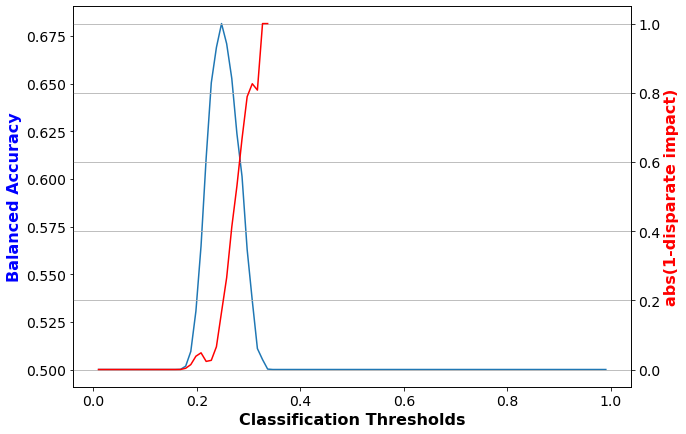

In [17]:
draw(data_imputed_test, data_imputed_transf_test)

In [20]:
# compare with original dataset
tmp_df = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                             protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                             features_to_keep=data_complete.X.columns.tolist(),
                             instance_weights_name=None, features_to_drop=[],
                             custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                            protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                            features_to_keep=data_complete.X.columns.tolist(),
                            instance_weights_name=None, features_to_drop=[],
                            custom_preprocessing=None, categorical_features=data_complete.categorical_features)
print(tmp_df_train.shape)
print(tmp_df_test.shape)
metric_train = BinaryLabelDatasetMetric(data_train, 
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
metric_test = BinaryLabelDatasetMetric(data_test, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
print(metric_train.mean_difference())
print(metric_test.mean_difference())

(22792, 11)
(9769, 11)
-0.1963298204586729
-0.19607737189595748


In [22]:
data_train.features = scaler.fit_transform(data_train.features)
data_test.features = scaler.transform(data_test.features)
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.01, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(data_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.7310505930273987, L_x: 2.5238689088829154,  L_y: 0.6895203927241166,  L_z: 0.008145755607226475
step: 250, loss: 0.7310506129759986, L_x: 2.523868931325602,  L_y: 0.6895204091832978,  L_z: 0.008145757239722362
step: 500, loss: 0.7310505638783231, L_x: 2.523868930367793,  L_y: 0.6895203814947546,  L_z: 0.008145746539945325
step: 750, loss: 0.640601645816017, L_x: 2.524060369456726,  L_y: 0.599625135647469,  L_z: 0.007867953236990377
step: 1000, loss: 0.640601667240875, L_x: 2.5240603877686114,  L_y: 0.5996251517685276,  L_z: 0.007867955797330626
step: 1250, loss: 0.6406016490832683, L_x: 2.524060393735345,  L_y: 0.5996251412341442,  L_z: 0.007867951955885294
step: 1500, loss: 0.5838020464033977, L_x: 2.524177757703068,  L_y: 0.544729219045182,  L_z: 0.006915524890592481
step: 1750, loss: 0.5838020594803612, L_x: 2.5241777529407416,  L_y: 0.5447292315234442,  L_z: 0.006915525213754804
step: 2000, loss: 0.579253457101116, L_x: 2.524113610319274,  L_y: 0.5412434151273066, 

In [23]:
data_transf_train = TR.transform(data_train)
data_transf_test = TR.transform(data_test)
print(classification_report(data_test.labels, data_transf_test.labels, zero_division=0))
metric_transf_train = BinaryLabelDatasetMetric(data_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
metric_transf_test = BinaryLabelDatasetMetric(data_transf_test, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print(metric_transf_train.mean_difference())
print(metric_transf_test.mean_difference())

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      7358
         1.0       0.00      0.00      0.00      2411

    accuracy                           0.75      9769
   macro avg       0.38      0.50      0.43      9769
weighted avg       0.57      0.75      0.65      9769

0.0
0.0


/home/archer/Downloads/AIF360/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/home/archer/Downloads/AIF360/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


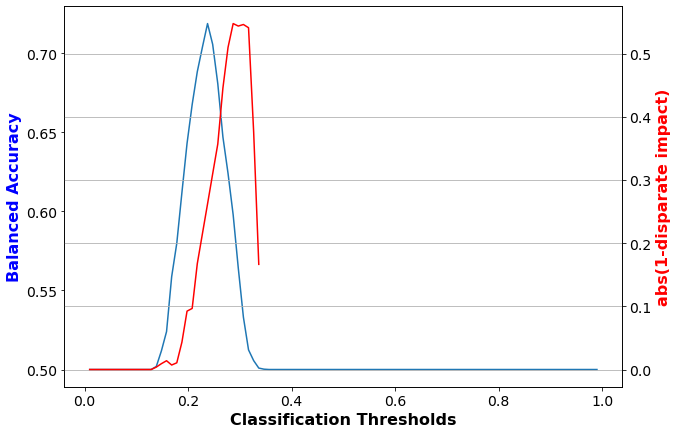

In [24]:
draw(data_test, data_transf_test)